In [1]:
import features_extraction
import numpy as np
import glob
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
PRED_PATH=r'../data/results/result.npy'


In [3]:
sig_npy = np.load(PRED_PATH)
# [gt, pred, cond]
sig_npy.shape

(3, 9984, 256)

In [4]:
ppg = sig_npy[2]
fs = 125

In [24]:
heads_feats = []
for i in trange(len(ppg)):
    try:
        feat = features_extraction.extract_feat_original(ppg[i], fs, filtered=True, remove_start_end=False)
        feat[0].append("signal_index")
        feat[1].append(i)
        heads_feats.append(feat)
    except Exception as e:
        print(i,e)

  0%|          | 0/9984 [00:00<?, ?it/s]f:\minowa\BloodPressureEstimation\notebooks\features_extraction.py:785: RuntimeWarning: Mean of empty slice.
  fft_peaks_neighbor_avgs.append(fft[start_idx:end_idx].mean())
f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 24%|██▎       | 2366/9984 [00:08<00:27, 282.09it/s]

2317 Feature extractor warning: There are no cycles
2320 Feature extractor warning: There are no cycles


 38%|███▊      | 3786/9984 [00:13<00:23, 258.53it/s]

3745 Feature extractor warning: There are no cycles
3778 Feature extractor warning: There are no cycles


 39%|███▊      | 3867/9984 [00:14<00:23, 263.91it/s]

3817 Feature extractor warning: There are no cycles
3832 Feature extractor warning: There are no cycles


 77%|███████▋  | 7642/9984 [00:27<00:07, 294.60it/s]

7605 Feature extractor warning: There are no cycles


100%|██████████| 9984/9984 [00:36<00:00, 277.20it/s]


In [69]:
def _extract_ppg_cycles(df):
    """ Compute and save the ppg cycles in dataframe.
        This function updates filtered signal. 
    """
    def _extract_c(sig, fs, pk_th=0.6, remove_start_end=False):
        """ Wrapper for extract_cycle_check function. """
        try:
            cs, pks_norm, flag1, flag2, pks, vlys = features_extraction.extract_cycle_check(sig, fs, pk_th, remove_start_end)
        except:
            cs, pks_norm, flag1, flag2, pks, vlys = [], [], True, True, [], []
        return cs, pks_norm, flag1, flag2, pks, vlys

    c_ppg = Parallel(n_jobs=-1)(delayed(_extract_c)(sig, fs=125, remove_start_end=False) for sig in df.fsignal)

    for i, label in enumerate(['cs','pks_norm','ppg_f1','ppg_f2','ppg_pks','ppg_vlys']):
        df[label] = [val[i] for val in c_ppg]
    not_computed = ((df['ppg_pks'].map(len)==0) | (df['ppg_f2']))
    # cl_log.write(" - removed by not computed: {} \n".format((not_computed).sum()))
    df = df[~not_computed].reset_index(drop=True)

    return df

In [70]:
df = pd.DataFrame(columns=["fsignal"])
df

,fsignal


In [71]:
df = pd.DataFrame(columns=["fsignal"])
for i in range(len(ppg)):
    tmp = {"fsignal":[],"signal_index":[]}
    tmp["fsignal"].append(ppg[i])
    tmp["signal_index"].append(i)
    a = pd.DataFrame(tmp)
    df = pd.concat([df,a])


In [72]:
df = df.reset_index(drop=True)
df

,fsignal,signal_index
0,"[0.07503849, 0.07990922, 0.09134481, 0.1102139...",0.0
1,"[0.11945733, 0.12067429, 0.12780768, 0.1419056...",1.0
2,"[0.10172083, 0.10734599, 0.12026503, 0.1412096...",2.0
3,"[0.10922458, 0.1131075, 0.12499966, 0.1459334,...",3.0
4,"[0.097520724, 0.10342789, 0.11683007, 0.138624...",4.0
...,...,...
9979,"[0.16962536, 0.17161354, 0.18245813, 0.2036410...",9979.0
9980,"[0.15691946, 0.16484866, 0.18302159, 0.2124706...",9980.0
9981,"[0.11448296, 0.1228383, 0.14179616, 0.17262514...",9981.0
9982,"[0.1478664, 0.15653732, 0.17590366, 0.20706359...",9982.0


In [73]:
df = _extract_ppg_cycles(df)

In [74]:
df.head()

,fsignal,signal_index,cs,pks_norm,ppg_f1,ppg_f2,ppg_pks,ppg_vlys
0,"[0.07503849, 0.07990922, 0.09134481, 0.1102139...",0.0,"[[0.07503849, 0.07990922, 0.09134481, 0.110213...","[26, 26]",False,False,"[26, 122]","[0, 96, 191]"
1,"[0.11945733, 0.12067429, 0.12780768, 0.1419056...",1.0,"[[0.11945733, 0.12067429, 0.12780768, 0.141905...","[26, 26]",False,False,"[26, 117]","[0, 91, 186]"
2,"[0.10172083, 0.10734599, 0.12026503, 0.1412096...",2.0,"[[0.10172083, 0.10734599, 0.12026503, 0.141209...","[24, 23]",False,False,"[24, 111]","[0, 88, 153]"
3,"[0.10922458, 0.1131075, 0.12499966, 0.1459334,...",3.0,"[[0.10922458, 0.1131075, 0.12499966, 0.1459334...","[21, 24]",False,False,"[21, 107]","[0, 83, 170]"
4,"[0.097520724, 0.10342789, 0.11683007, 0.138624...",4.0,"[[0.097520724, 0.10342789, 0.11683007, 0.13862...","[24, 25]",False,False,"[24, 110]","[0, 85, 173]"


In [75]:
def _wrapper_compute_features_parallel(df):
    # 並列で処理する関数を定義
    def process_row(row):
        try:
            feat_name, feats = features_extraction.extract_feat_cycle(row.cs, row.pks_norm, fs=fs)
            feat_name = np.append(feat_name,"signal_index")
            feats = np.append(feats,row.signal_index)
            return feat_name, feats
        except Exception as e:
            # print(e)
            return None  # 失敗した場合はNoneを返す
    
    # df.iterrows()の各行に対してprocess_rowを並列に適用
    # heads_feats = Parallel(n_jobs=-1)(
    #     delayed(process_row)(row) for _, row in df.iterrows()
    # )
    heads_feats = [process_row(row)for _,row in df.iterrows()]
    
    # Noneを取り除く
    heads_feats = [feat for feat in heads_feats if feat is not None]

    return heads_feats

In [76]:
heads_feats = _wrapper_compute_features_parallel(df)
list_2 = []
for i,(h,f) in enumerate(heads_feats):
    if len(h)==0 or len(f) == 0:
        list_2.append(i)

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats]
res_second = pd.DataFrame(list_series)

f:\minowa\BloodPressureEstimation\notebooks\features_extraction.py:552: RuntimeWarning: invalid value encountered in divide
  bd = (vpg[d+1] - vpg[b+1])/(d-b)


In [79]:
res_second.head()

,Tc,Ts,Td,Tsteepest,Steepest,TNegSteepest,NegSteepest,TdiaRise,DiaRise,SteepDiaRise,...,T_peak_a_norm,T_peak_b_norm,T_peak_c_norm,T_peak_d_norm,T_peak_e_norm,AI,bd,bcda,sdoo,signal_index
0,0.764,0.208,0.556,0.072,0.055331,0.272,-0.026202,0.364,0.509990,-0.008231,...,0.251316,0.130866,-0.052357,0.015680,0.136129,-0.180376,-0.003336,0.143385,0.001699,0.0
1,0.744,0.208,0.536,0.072,0.054066,0.268,-0.027529,0.364,0.487952,-0.007943,...,0.247426,0.134586,-0.059283,0.016021,0.134355,-0.188768,-0.003442,0.172218,0.002079,1.0
2,0.612,0.188,0.424,0.064,0.049222,0.264,-0.028667,0.360,0.383425,-0.006888,...,0.286538,0.139423,-0.045804,0.040122,0.173864,-0.266038,-0.003216,0.080183,0.006862,2.0
3,0.680,0.180,0.500,0.068,0.061619,0.252,-0.029277,0.348,0.452764,-0.006271,...,0.235147,0.105664,-0.017518,0.035037,0.170544,-0.373124,-0.004215,-0.024197,0.006013,3.0
4,0.692,0.196,0.496,0.068,0.060229,0.260,-0.031534,0.356,0.457563,-0.008157,...,0.254412,0.127206,-0.052139,0.023128,0.150334,-0.250745,-0.003838,0.116949,0.003208,4.0


In [121]:
heads_feats_first = Parallel(n_jobs=-1)(delayed(features_extraction.extract_feat_original)(fsig, fs=fs, filtered = True, remove_start_end=False) for fsig in df['fsignal'])
list_2_1 = []
for i,(h,f) in enumerate(heads_feats_first):
    if len(h)==0 or len(f) == 0:
        list_2_1.append(i)
        

list_series = [pd.Series(f, index=h, dtype='float64') for h,f in heads_feats_first]
res = pd.DataFrame(list_series)

template = pd.read_csv("columns_template.csv")['columns'].values

In [81]:
# cols = []
# for c in template:
#     if c in res.columns:
#         cols.append(c)

# res_first=res[cols].copy()

# data_feats = pd.concat([res_first,res_second], axis=1)
# data_feats = data_feats.drop(index=list_2+list_2_1).reset_index(drop=True)
# df = df.drop(index=list_2+list_2_1).reset_index(drop=True)
data_feats = res_second
keep_mask = ~data_feats.isna()['bd']

# data_feats = data_feats[keep_mask].reset_index(drop=True)
# df = df[keep_mask].reset_index(drop=True)

data_feats = data_feats.replace([np.inf, -np.inf], 0)
data_feats['signal_index']= data_feats['signal_index'].astype('int')


In [82]:
data_feats.to_csv(r"../data/results/ppg_features_small.csv")

In [1]:
data_feats.columns

NameError: name 'data_feats' is not defined

In [ ]:
data_feats.i

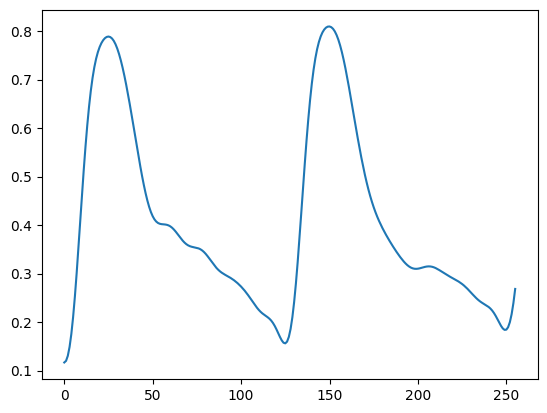

In [20]:
plt.plot(ppg[9822])

In [5]:
scales = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")
gt = sig_npy[0]
out = sig_npy[1]
def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)
gt[:] -= scales[0,0]
gt[:] /= scales[0,1]
out[:] -= scales[0,0]
out[:] /= scales[0,1]
gt_min,gt_max = calc_min_max(gt)
out_min,out_max = calc_min_max(out)
errors = np.zeros((2,*out_min.shape))
errors[0,:]=gt_min-out_min
errors[1,:]=gt_max-out_max

# get errors (target variable)

In [84]:
index = pd.read_csv(r"../data/results/ppg_features_small.csv")["signal_index"].values
index

array([   0,    1,    2, ..., 9981, 9982, 9983], dtype=int64)

In [85]:
errors = errors[:,index]
errors.shape

(2, 6974)

In [6]:
df = pd.DataFrame(errors.reshape(-1,2),columns=["err_DBP","err_SBP"])
df["abs_err_DBP"] =np.abs(df['err_DBP'])
df["abs_err_SBP"] =np.abs(df['err_SBP'])

In [7]:
c_DBP = [
    abs(df['abs_err_DBP']) < 5,
    (df['abs_err_DBP'] >= 5) & (df['abs_err_DBP'] < 15),
    df['abs_err_DBP'] >= 15
]
c_SBP = [
    abs(df['abs_err_SBP']) < 5,
    (df['abs_err_SBP'] >= 5) & (df['abs_err_SBP'] < 15),
    df['abs_err_SBP'] >= 15
]
choices = [0, 1, 2]

In [8]:
df['target_SBP'] = np.select(c_SBP, choices)
df['target_DBP'] = np.select(c_DBP, choices)

In [9]:
df.head()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP
0,-6.893147,-9.505203,6.893147,9.505203,1,1
1,-5.536797,-5.235329,5.536797,5.235329,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2
4,-21.217396,-3.074295,21.217396,3.074295,0,2


In [90]:
df["signal_index"] = index
df

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,signal_index
0,-6.893147,-9.505203,6.893147,9.505203,1,1,0
1,-5.536797,-5.235329,5.536797,5.235329,1,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2,3
4,-21.217396,-3.074295,21.217396,3.074295,0,2,4
...,...,...,...,...,...,...,...
6969,-22.324524,30.808670,22.324524,30.808670,2,2,9979
6970,36.928764,23.052505,36.928764,23.052505,2,2,9980
6971,24.505508,16.756897,24.505508,16.756897,2,2,9981
6972,21.385239,14.779999,21.385239,14.779999,1,2,9982


In [91]:
df.head ()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,signal_index
0,-6.893147,-9.505203,6.893147,9.505203,1,1,0
1,-5.536797,-5.235329,5.536797,5.235329,1,1,1
2,-18.116745,6.519360,18.116745,6.519360,1,2,2
3,-36.884052,-19.033958,36.884052,19.033958,2,2,3
4,-21.217396,-3.074295,21.217396,3.074295,0,2,4


In [92]:
df.to_csv("../data/results/target.csv")

In [93]:
df2 = pd.read_csv(r"../data/results/ppg_features_small.csv",index_col=0)

In [94]:
df = df.drop(columns=["err_DBP",	"err_SBP",	"abs_err_DBP"	,"abs_err_SBP"	],axis=1)
df3 = pd.merge(df, df2)

In [63]:
df3.head()

,target_SBP,target_DBP,signal_index,ppg_fft_peaks_0,ppg_fft_peaks_heights_0,ppg_fft_peaks_neighbor_avgs_0,hr_0,p2p_0,ppg_max_neighbor_mean_0,ppg_min_0,...,T_peak_e,T_peak_a_norm,T_peak_b_norm,T_peak_c_norm,T_peak_d_norm,T_peak_e_norm,AI,bd,bcda,sdoo
0,1,1,0,2.0,0.754521,NaN,78.534031,95.5,0.972788,78.0,...,0.104,0.251316,0.130866,-0.052357,0.015680,0.136129,-0.180376,-0.003336,0.143385,0.001699
1,1,1,1,2.0,0.806550,NaN,80.213904,93.5,0.972666,77.0,...,0.100,0.247426,0.134586,-0.059283,0.016021,0.134355,-0.188768,-0.003442,0.172218,0.002079
2,1,2,2,2.0,0.891950,NaN,89.820359,83.5,0.978434,0.0,...,0.104,0.286538,0.139423,-0.045804,0.040122,0.173864,-0.266038,-0.003216,0.080183,0.006862
3,2,2,3,2.0,0.905759,NaN,87.209302,86.0,0.978911,78.0,...,0.116,0.235147,0.105664,-0.017518,0.035037,0.170544,-0.373124,-0.004215,-0.024197,0.006013
4,0,2,4,2.0,0.908642,NaN,86.206897,87.0,0.977175,77.0,...,0.104,0.254412,0.127206,-0.052139,0.023128,0.150334,-0.250745,-0.003838,0.116949,0.003208


In [95]:
df3.to_csv(r"../data/results/ppg_features_all_small.csv")

# 2

In [10]:
df["gt_SBP"] = gt_max
df["gt_DBP"] = gt_min

In [12]:
corr = []
for i in range(len(sig_npy[0])):
    corr.append(np.corrcoef(sig_npy[0,i],sig_npy[2,i])[0,1])

In [13]:
corr

[0.9444729294170073,
 0.9446229203204158,
 0.9151107794857999,
 0.9541802313327157,
 0.9509273931941998,
 0.9520772936593662,
 0.9475267212302262,
 0.9492015328666747,
 0.9220671704976137,
 0.9635175524287398,
 0.9371902945671653,
 0.9106850272453154,
 0.9262887751137725,
 0.9418695221228539,
 0.9355112892079309,
 0.9217351405374885,
 0.9427794191620805,
 0.9368555053131218,
 0.9429061143776544,
 0.9389749144415758,
 0.9497189146884659,
 0.9523187434554121,
 0.8127292864875794,
 0.9675629720202115,
 0.9641818418661285,
 0.9525430466892387,
 0.9720884890013316,
 0.9053335460999163,
 0.9389073575638326,
 0.905333563882703,
 0.9389073413550437,
 0.9887336686771414,
 0.9834085664484231,
 0.9715363119838196,
 0.9674659647978925,
 0.9507390323736138,
 0.9934353477454009,
 0.9946762420404677,
 0.9892708152238399,
 0.9750889741198272,
 0.9890659292463817,
 0.9618054488802733,
 0.9819253625525156,
 0.9692224491302406,
 0.9744100696656238,
 0.9908090555541958,
 0.9582328723445638,
 0.97659237536

In [14]:
df["corr"] = corr

In [19]:
from scipy.stats import *

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)


In [ ]:
m = a.mean(axis)
sd = a.std(axis=axis, ddof=ddof)
return np.where(sd == 0, 0, m/sd)

In [17]:
Nsqi = signaltonoise(sig_npy[2],axis=1)

In [20]:
Ksqi = kurtosis(sig_npy[2],axis=1)

In [22]:
Ssqi = skew(sig_npy[2],axis=1)

In [23]:
df["Nsqi"] = Nsqi
df["Ksqi"] = Ksqi
df["Ssqi"] = Ssqi

In [24]:
df.head()

,err_DBP,err_SBP,abs_err_DBP,abs_err_SBP,target_SBP,target_DBP,gt_SBP,gt_DBP,corr,Nsqi,Ksqi,Ssqi
0,-6.893147,-9.505203,6.893147,9.505203,1,1,108.433914,58.222172,0.944473,1.853424,-1.248914,0.115490
1,-5.536797,-5.235329,5.536797,5.235329,1,1,108.189690,58.466393,0.944623,1.868523,-1.225156,0.197390
2,-18.116745,6.519360,18.116745,6.519360,1,2,113.660225,66.427979,0.915111,2.295434,-1.221087,0.327870
3,-36.884052,-19.033958,36.884052,19.033958,2,2,108.482758,60.127090,0.954180,1.716473,-1.180554,0.353749
4,-21.217396,-3.074295,21.217396,3.074295,0,2,115.223244,64.669594,0.950927,1.708668,-1.211760,0.315057


In [25]:
df.to_csv(r"../data/results/stats_features.csv")

In [30]:
df2=df.loc[:,["target_SBP","target_DBP"]]
df2.head()

,target_SBP,target_DBP
0,1,1
1,1,1
2,1,2
3,2,2
4,0,2


In [31]:
df2.to_csv(r"../data/results/stats_targets.csv")